In [1]:
from image_compressor.svd_compressor import SVDCompressor
from image_compressor.svd import svd
from image_compressor.compressed import Compressed
from image_compressor.evaluation import mse, psnr, pearson_correlation, cr

In [2]:
# add metrics
def er_score(image, U, singular_values, V, rank):
    original_energy = np.sum(singular_values ** 2)
    current_energy = np.sum(singular_values[:rank] ** 2)
    return current_energy / original_energy

def ssim_score(image, U, singular_values, V, rank):
    L = 255
    k1 = 0.01
    k2 = 0.03
    c1 = (k1 * L) ** 2
    c2 = (k2 * L) ** 2
    c3 = c2 / 2
    
    X = image
    Y = (U[:, :rank] @ np.diag(singular_values[:rank]) @ V[:rank, :]).astype(np.float32)
    mu1, mu2 = np.average(X), np.average(Y)
    luminance = (2 * mu1 * mu2 + c1) / (mu1 ** 2 + mu2 ** 2 + c1)
    std1, std2 = np.std(X), np.std(Y)
    contrast = (2 * std1 * std2 + c2) / (std1 ** 2 + std2 ** 2 + c2)
    covariance = np.matmul((X - mu1).flatten(), (Y - mu2).flatten()) / X.size
    structure = (covariance + c3) / (std1 * std2 + c3)
    return luminance * contrast * structure

In [3]:
# update svd compressor that also take rank in function compress and return image, ssim and er
class SVDCompressor_rank():
    def compress(self, image, ranks):
        image = image.astype(np.float32)
        m, n = image.shape
        transposed = False
        if n > m:
            image = image.T
            transposed = True
        U, S, V = svd(image)
        if n > m:
            U, V = V.T, U.T

        singular_values = np.diag(S)
        indexes = np.argsort(singular_values)[::-1]
        U = U[:, indexes]
        V = V[indexes, :]
        singular_values = singular_values[indexes]
        if transposed:
            image = image.T
            
        if type(ranks) == list:
            return [[Compressed(U[:, :rank], singular_values[:rank], V[:rank, :]), \
                    ssim_score(image, U, singular_values, V, rank), er_score(image, U, singular_values, V, rank)] for rank in ranks]
        else:            
            return Compressed(U[:, :ranks], singular_values[:ranks], V[:ranks, :]), \
                    ssim_score(image, U, singular_values, V, ranks), er_score(image, U, singular_values, V, ranks)

# Experiments

In [4]:
import numpy as np
import pandas
import cv2
import matplotlib.pyplot as plt

def compress_image(image, ranks):
    compressor = SVDCompressor_rank()
    compressor_data = compressor.compress(image, ranks)
    return [[compressed.to_image(), compressed.get_effective_rank(), mse(image, compressed), psnr(image, compressed),\
            pearson_correlation(image, compressed), cr(image, compressed), ssim, er] for compressed, ssim, er in compressor_data]

In [5]:
image = cv2.imread("image/barack_obama.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

output = compress_image(image, [2**i for i in range(9)])
table = pandas.DataFrame([i[1:] for i in output], columns = ["Rank", "MSE", "PSNR", "PR", "CR", "SSIM", "ER"])

for i in range(len(output)):
    cv2.imwrite("image/obama_compressed_{}.jpg".format(output[i][1]), output[i][0])
    

In [6]:
table1 = table.copy()
float_columns = ["MSE", "PSNR", "PR", "SSIM", "ER"]
for column in float_columns:
    table1[column] = table1[column].apply(lambda x: round(x, 4))
table1.to_csv("table.csv", index= False)
table1

,Rank,MSE,PSNR,PR,CR,SSIM,ER
0,1,0.2618,53.9518,0.5766,256.0,0.5106,0.7795
1,2,0.2463,54.2167,0.7203,128.0,0.6896,0.8411
2,4,0.2482,54.1821,0.8282,64.0,0.8142,0.8954
3,8,0.2487,54.1742,0.9042,32.0,0.9002,0.9395
4,16,0.2489,54.1710,0.9519,16.0,0.9508,0.9688
5,32,0.2393,54.3421,0.9800,8.0,0.9798,0.9868
6,64,0.2457,54.2266,0.9928,4.0,0.9928,0.9952
7,128,0.2583,54.0103,0.9978,2.0,0.9978,0.9986
8,256,0.2622,53.9445,0.9998,1.0,0.9998,0.9999


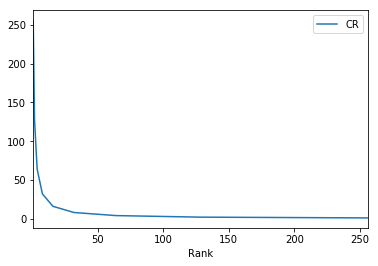

In [7]:
plot = table.plot(x="Rank", y = "CR")

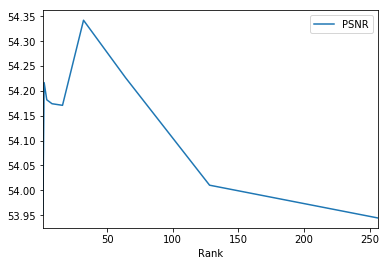

In [8]:
plot = table.plot(x="Rank", y = "PSNR")

In [10]:
def mse1(image, compressed_image):
    difference = (image - compressed_image) ** 2
    return sum(sum(difference)) / image.size

mse1(np.array([[1], [2]], type=np.float32), np.array([[0], [4]]))

TypeError: 'type' is an invalid keyword argument for array()